I'm converting the runner to a notebook so I can run it chunk by chunk and see the output:

# Imports

In [1]:
import math
import numpy as np
from scipy.io import loadmat
import torch
import gpytorch
from matplotlib import pyplot as plt
import dk_kernel

# Train and test data

In [2]:
train_x = torch.linspace(0, 1, 100)
test_x = torch.linspace(0.1, 1.1, 52)
train_y = torch.stack(
    [torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

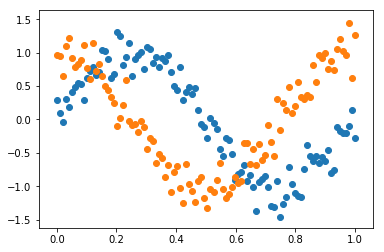

In [3]:
plt.scatter(train_x.numpy(),train_y[:,0].numpy())
plt.scatter(train_x.numpy(),train_y[:,1].numpy())
plt.show()

# Create kernel

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = dk_kernel.MultitaskRBFKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)
model.covar_module.log_task_lengthscales[0] = 0
model.covar_module.log_task_lengthscales[1] = 1

In [5]:
model.covar_module(train_x,train_x).evaluate()


torch.Size([1, 100, 100])


tensor([[1.0000, 0.9999, 0.9998,  ..., 0.0000, 0.0000, 0.0000],
        [0.9999, 1.0000, 0.9999,  ..., 0.0000, 0.0000, 0.0000],
        [0.9998, 0.9999, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.9999, 0.9998],
        [0.0000, 0.0000, 0.0000,  ..., 0.9999, 1.0000, 0.9999],
        [0.0000, 0.0000, 0.0000,  ..., 0.9998, 0.9999, 1.0000]],
       grad_fn=<Matmul>)

# Train hyperparameters

In [6]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

ValueError: can't optimize a non-leaf Tensor

Make predictions

In [71]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Plot means and training data

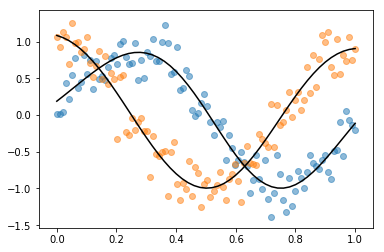

In [72]:
# training data and posterior mean from task 0
plt.scatter(train_x.detach().numpy(), train_y[:, 0].detach().numpy(),color='C0',alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 0].numpy(), 'black')
# training data and posterior mean from task 1
plt.scatter(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), color='C1',alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 1].numpy(), 'black')


# Plot means and confidence region


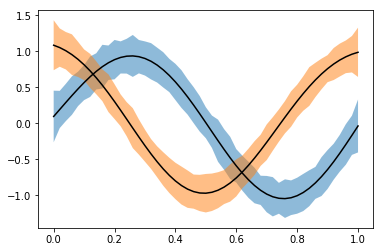

In [8]:
# training data and posterior mean from task 0
plt.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 0].numpy(), 'black')
# training data and posterior mean from task 1
plt.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 1].numpy(), 'black')


LazyTensor testing

In [65]:
from gpytorch.lazy import LazyTensor,NonLazyTensor,BlockDiagLazyTensor
a=torch.Tensor([[1,1],[1,1]])
b=torch.Tensor([[2,2],[2,2]])
b=NonLazyTensor(torch.stack((a.mul(20),b.mul(30))))
c=BlockDiagLazyTensor(b)
c.size()
c.evaluate()


tensor([[20., 20.,  0.,  0.],
        [20., 20.,  0.,  0.],
        [ 0.,  0., 60., 60.],
        [ 0.,  0., 60., 60.]])